<a href="https://colab.research.google.com/github/AntonPrazdnichnykh/dul_2021/blob/hw3/Homework/hw3/Homework3_autoregressive_flows.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!nvidia-smi

Tue Nov 23 20:05:03 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone --single-branch https://github.com/GrigoryBartosh/dul_2021
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 180, done.
remote: Counting objects: 100% (180/180), done.
remote: Compressing objects: 100% (119/119), done.
remote: Total 180 (delta 80), reused 130 (delta 43), pack-reused 0
Receiving objects: 100% (180/180), 28.69 MiB | 26.74 MiB/s, done.
Resolving deltas: 100% (80/80), done.
Processing ./dul_2021
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for dul-2021: filename=dul_2021-0.1.0-py3-none-any.whl size=15097 sha256=7739b69c3201dce1a338a32c3670b9d0dc6aae1ca8ddf440c69435e1f162c8b1
  Stored in directory: /tmp/pip-ephem-wheel-cache-le5p0uov/wheels/55/59/29/0fb1c63565215773

In [1]:
from dul_2021.utils.hw3_utils import *

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam
# from tqdm.notebook import tqdm
from tqdm import trange
from torch.utils.data import DataLoader
from torch.distributions.uniform import Uniform
from torch.distributions.normal import Normal
from scipy.stats import norm
from scipy.optimize import bisect

In [3]:
import matplotlib.pyplot as plt


# Question 1: Autoregressive Flows for Images

Adapt your PixelCNN implementation from Homework 2 and use it as an autoregressive flow model on the black-and-white shapes dataset. Using the base architecture from Homework 2 1(a), output a mixture of logistics or gaussians (instead of logits), whose CDF we will use as our flow for each dimension of x. 

Remember: you must dequantize the data and scale it between 0 and 1 for the autoregressive flow to have stable training. 

**You will provide these deliverables**

1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. **Make sure to account for any rescaling you do in your nats/dim.**
2.   Report the final test set performance of your final model
3. 100 samples from your autoregressive flow. Our plotting code will show your samples, with and without clipping and flooring (to remove the quantization). 


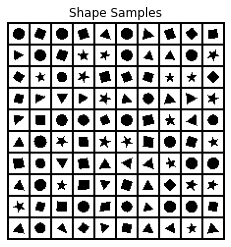

In [4]:
visualize_q1_data()

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [5]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [6]:
class MaskedConv2d(nn.Conv2d):
  def __init__(self, mask_type, *args, **kwargs):
    assert mask_type in ['A', 'B'], "Possible mask types are A and B"
    super().__init__(*args, **kwargs)
    out_channels, in_channels, h, w = self.weight.size()
   
    self.register_buffer('mask', torch.ones_like(self.weight))
    if mask_type == 'A':
      self.mask[:, :, h // 2, w // 2:] = 0
      self.mask[:, :, h // 2 + 1:, :] = 0
    else:
      self.mask[: ,: , h // 2, w // 2 + 1:] = 0
      self.mask[:, :, h // 2 + 1:, :] = 0
      

  def forward(self, x):
    self.weight.data *= self.mask
    return super().forward(x)


In [7]:
class ResidualBlock(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size):
    assert out_channels % 2 == 0
    super().__init__()
    self.net = nn.Sequential(
        MaskedConv2d('B', in_channels, out_channels // 2, 1),
        nn.ReLU(),
        MaskedConv2d('B', out_channels // 2, out_channels // 2, kernel_size, padding='same', bias=False),
        nn.ReLU(),
        MaskedConv2d('B', out_channels // 2, out_channels, 1),
        nn.ReLU()
        )
    
  def forward(self, x):
    return x + self.net(x)

In [8]:
class PixelCNN(nn.Module):
  def __init__(self, n_blocks, in_channels, n_channels, out_channels):
    super().__init__()

    self.net = nn.Sequential(
        MaskedConv2d('A', in_channels, n_channels, kernel_size=7, padding='same'),
        nn.ReLU(),
        *[ResidualBlock(n_channels, n_channels, 7) for _ in range(n_blocks)],
        MaskedConv2d('B', n_channels, out_channels * in_channels, 1)
    )

  def forward(self, x):
    return self.net(x)


In [9]:
class FlowModel(nn.Module):
    def test(self, test_loader):
        self.eval()
        total_loss = 0
        tc = 0
        with torch.no_grad():
            for x in test_loader:
                x = x.to(device).float()
                loss = self.nll(x)
                total_loss += loss * x.shape[0]
                tc += x.shape[0]
        self.train()
        return total_loss.item() / tc

    def fit(self, train_data, test_data, num_epochs=100, lr=5e-3, batch_size=128):
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_data, batch_size=batch_size)

        optim = Adam(self.parameters(), lr=lr)

        train_losses = []
        test_losses = []

        test_losses.append(self.test(test_loader))

        for epoch in trange(num_epochs, desc='training'):
            avg_loss = 0
            n_samples = 0
            for x in train_loader:
                bs = x.size(0)
                x = x.to(device).float()
                loss = self.nll(x)
                avg_loss += bs * loss.item()
                n_samples += bs
                optim.zero_grad()
                loss.backward()
                optim.step()

            train_losses.append(avg_loss / n_samples)
            test_losses.append(self.test(test_loader))

        return train_losses, test_losses

    def nll(self, x):
        raise NotImplementedError()

    def flow(self, x):
        raise NotImplementedError()

    def inverse(self, z):
        raise NotImplementedError()

    def log_prob(self, x):
        raise NotImplementedError()
        
    def get_density(self):
        x = np.linspace(self.plot_b[0], self.plot_b[1], 1000)
        with torch.no_grad():
            y = self.log_prob(torch.FloatTensor(x)).exp().cpu().numpy()
        return x, y


In [10]:
class ARFlow(FlowModel):
    def __init__(self, n_blocks=8, in_channels=1, n_channels=120, k2=5):
        super().__init__()
        self.pixel_cnn = PixelCNN(n_blocks, in_channels, n_channels, out_channels=3 * k2)
        self.pixel_cnn.to(device)
        self.k2 = k2
        self.bdist = Uniform(torch.tensor([0.], device=device), torch.tensor([1.], device=device))

    def flow(self, x):
        mu, log_s, log_w = torch.chunk(self.pixel_cnn(x), 3, dim=1)
        w = F.softmax(log_w, dim=1)
        mix_dist = Normal(mu, log_s.exp())

        x_ = x.repeat(1, self.k2, 1, 1)

        z = (w * mix_dist.cdf(x_)).sum(dim=1)
        log_det = (w * mix_dist.log_prob(x_).exp()).sum(dim=1).log() - torch.tensor([2.], device=device).log()

        return z, log_det

    def inverse(self, w, mu, s):
      batch_size = w.size(0)
      z = self.bdist.sample((batch_size,))
      ans = []
      for i in range(batch_size):
        mix_dist = Normal(mu[i], s[i])
        def f(x):
          x = torch.tensor(x, device=device).repeat(self.k2)
          # print('w[i]:', w[i].shape, 'x:', x.shape, 'cdf:', mix_dist.cdf(x).shape)
          return w[i].dot(mix_dist.cdf(x)) - z[i]
        ans.append(bisect(f, -20, 20))
      return torch.tensor(ans, device=device)

    def sample(self, n_samples, h, w):
      sampled = torch.zeros((n_samples, h, w), device=device)
      for h_ in trange(h, desc='sampling'):
        for w_ in range(w):
          mu, log_s, log_w = torch.chunk(self.pixel_cnn(sampled.unsqueeze(1))[:, :, h_, w_], 3, dim=1)
          sampled[:, h_, w_] = self.inverse(F.softmax(log_w, dim=1), mu, log_s.exp())
      return torch.clip(sampled, 0, 1)

                
    def log_prob(self, x):
        z, log_det = self.flow(x)
        # print('z:', z.shape, z, sep='\n')
        # print('log_det:', log_det.shape, log_det, sep='\n')
        z = torch.clip(z, 0, 1)
        return (self.bdist.log_prob(z) + log_det).mean(dim=(1, 2))

    def nll(self, x):
        return - self.log_prob(x).mean()

In [11]:
PARAMS = {
    'num_epochs':10, 
    'lr':1e-3, 
    'batch_size':128
}

In [12]:
def dequantize(x, quants=2):
  x = x.float()
  x = x + torch.rand_like(x)
  x = x / quants
  return x

In [13]:
def q1(train_data, test_data):
  """
  train_data: A (n_train, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
  test_data: A (n_test, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
  H = W = 20
  Note that you should dequantize your train and test data, your dequantized pixels should all lie in [0,1]

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, 1) of samples with values in [0, 1], where [0,0.5] represents a black pixel
      and [0.5,1] represents a white pixel. We will show your samples with and without noise. 
  """
  
  _, h, w, _ = train_data.shape
  train_data = dequantize(torch.tensor(train_data.squeeze(3)).unsqueeze(1))
  test_data = dequantize(torch.tensor(test_data.squeeze(3)).unsqueeze(1))
  model = ARFlow(n_blocks=8, in_channels=1, n_channels=120, k2=5)

  # train
  train_losses, test_losses = model.fit(train_data, test_data, **PARAMS)
  sampled = model.sample(100, h, w)
  # plt.plot(train_losses, label='train')
  # plt.plot(test_losses, label='test')
  # plt.show()

  return train_losses, test_losses , sampled.unsqueeze(3).cpu().numpy()


### Results

Once you've implemented `q1`, execute the cells below to visualize and save your results



sampling: 100%|██████████| 20/20 [13:45<00:00, 41.26s/it]


Final Test Loss: 0.1569


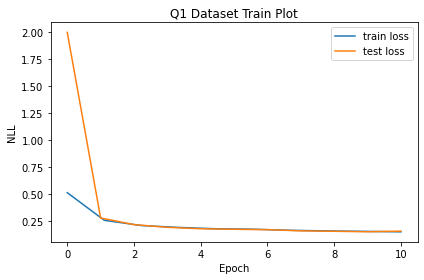

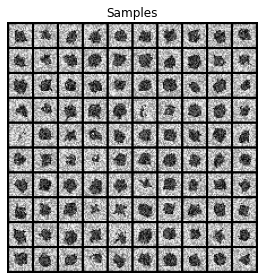

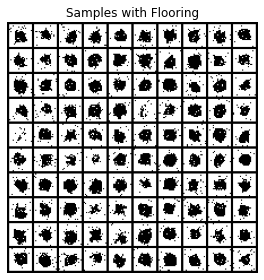

In [14]:
q1_save_results(q1)